<h2 style='font-size:30px'>Loading and Scaling the Dataset </h2>

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Loading the data..
X,y = load_breast_cancer(return_X_y=True)

# Splitting the training and test sets and scaling the numbers.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

<h2 style='font-size:30px'> Outlier Detection and Removal</h2>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            For this section, I will carry out the exclusion of outliers for each cell class. It would not be reasonable to perform it in the whole training set since the objects under analysis have different properties.
        </li>
    </ul>
</div>

<h3 style='font-size:30px;font-style:italic'> Malign Outliers Treatment</h3>

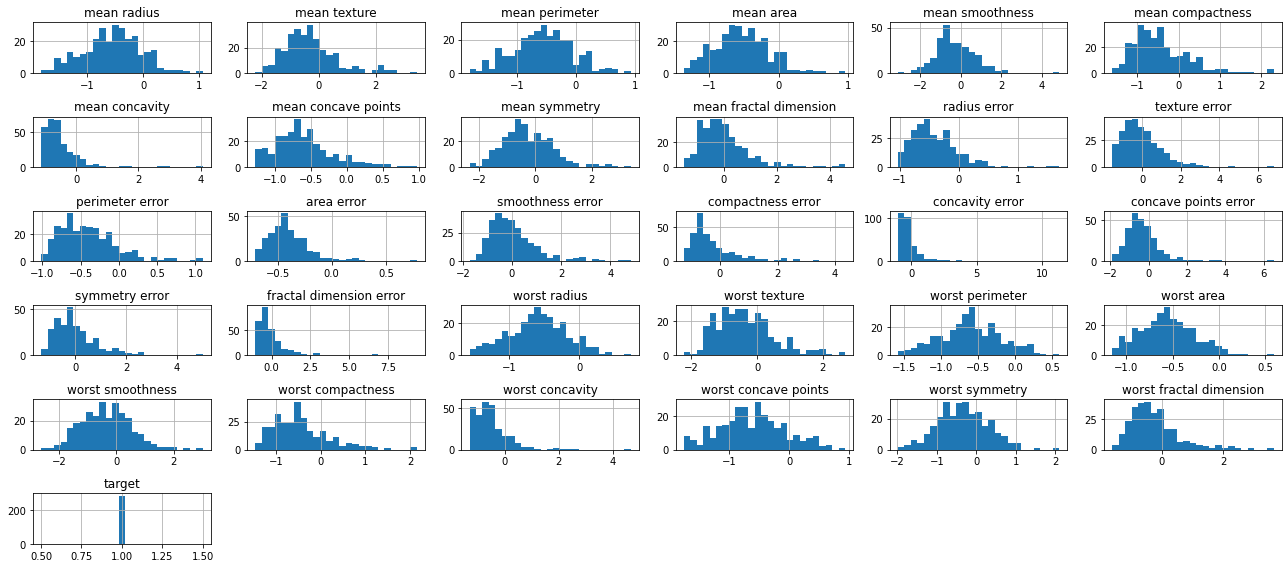

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# I am invoking 'load_breast_cancer' again so that we can get the feature names.
breast_cancer = load_breast_cancer()
train = pd.DataFrame(np.concatenate((X_train_scaled, y_train.reshape(-1,1)), axis=1),
                    columns=np.append(breast_cancer['feature_names'], 'target'))

# Obtaining exclusively the malign cells data.
malign = train[train.target==1]
malign.hist(bins=25, figsize=(18,8));
plt.tight_layout()

<div> 
    <ul style='font-size:20px'> 
        <li> 
            There are two major shapes in our histograms. Some of the features resemble a Chi-Square Distribution, with most of their values concentrated in the left portion of the graphs. On the other hand, the majority of the columns has its values converging to a number both from the left and right sections of the chart.
        </li>
        <li> 
            The distinct natures of such distributions demand different treatment of their outliers.
        </li>
    </ul>
</div>

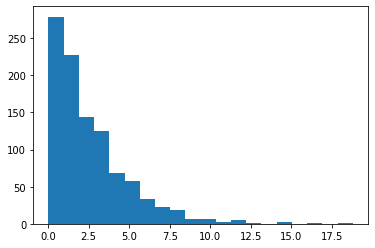

In [4]:
# Plotting a 2.5 Degrees of Freedom Chi-Square Distribution. Note that its shape is similar with some of the plots of the figure above.
plt.hist(np.random.chisquare(2.5, 1000).reshape(-1,1), bins=20);

<h4 style='font-size:30px;font-style:italic;text-decoration:underline'> Chi-Square Features Treatment</h4>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            As the chart just created presents, chi-square distributions tend to have most of their values concentrated on the left portion of the x-axis; as we move toward the right section, the values become scarcer. In the setting of a ML project, it is not interesting to keep such rare numbers in our dataset, they need to be removed so that the algorithms can achieve greater performances.
        </li>
    </ul>
</div>

In [5]:
# Let's list all the columns that appear to approximately have the shape of a Chi-Square Distribution.
chi_sqr = ['mean concavity', 'compactness error', 'concavity error',  'fractal dimension error','worst concavity', 'texture error']

# Removing all the lines which cells are considered outliers in any of the features from the 'chi_sqr' list (using the IQR technique).
maling_chi_sqr = malign[chi_sqr]
iqr = 1.5 * np.percentile(maling_chi_sqr, 75, axis=0) - np.percentile(maling_chi_sqr, 25, axis=0)
to_drop_maling_chi_sqr = maling_chi_sqr[(maling_chi_sqr > iqr).any(axis=1)].index

<h4 style='font-size:30px;font-style:italic;text-decoration:underline'> Remaining Features Treatment</h4>
<div> 
    <ul style='font-size:20px'> 
        <li> 
            The other features available show the greater portion of their instances in the graphs' central area. It's noticeable that as we move towards the fringes of the x-axis, the data points density tends to decrease.
        </li>
        <li> 
            Hence, our task is to find the instances from those extremely low populated regions and rip them off from the dataset. 
        </li>
    </ul>
</div>

In [30]:
# Listing all the features with the mentioned characteristics.
central = list(malign.columns)
for col in chi_sqr:
    central.remove(col)
central.remove('target')

In [7]:
# !REFAZER ESTA SEÇÃO !!
# Sectioning the 'malign' DataFrame with 'normal'.
malign_normal = malign[normal]

# Now, deleting rows based on the IQR rule. I've raised the multiplier factor from 1.5 to 1.75 because the first value would cause
# the removal of a high number of cells.
iqr = 1.75 * (malign_normal.quantile(.75) - malign_normal.quantile(.25)) 

# 'to_drop1' mentions all the rows that have one of its values below the 25th quantile - IQR of any given column.
to_drop1 = ((malign_normal < malign_normal.quantile(.25) - iqr)
            .any(axis=1)
            .where(lambda x: x==True)
            .dropna()
            .index)

# 'to_drop2' presents the rows which values exceed the 75th quantile + IQR of any given column.
to_drop2 = ((malign_normal > malign_normal.quantile(.75) + iqr)
            .any(axis=1)
            .where(lambda x: x==True)
            .dropna()
            .index)
# Continuar daqui!!!

In [8]:
# The reason of choosing XGBoost as our feature selection classifier was its usual high performance in most of the projects and also
# the fact that it presents the convenient 'feature_importances' attribute.

from keras_tuner import SklearnTuner, HyperParameters
from keras_tuner.oracles import BayesianOptimization
from xgboost import XGBClassifier


# Constructing the algorithm.
def build_model(hp):
    model = XGBClassifier(
        n_estimators = hp.Int('n_estimators', min_value=30, max_value=100, step=10),
        max_depth = hp.Int('max_depth', min_value=2, max_value=4, step=1),
        gamma = hp.Float('gamma', min_value=.05, max_value=.5, step=.05),
        colsample_bytree = hp.Float('colsample_bytree', min_value=.1, max_value=.5, step=.1)
        )
    return model

2022-09-25 19:24:13.136765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /u01/app/oracle/product/11.2.0/xe/lib:/lib:/usr/local/lib:
2022-09-25 19:24:13.136819: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
# Now, let's use K-Means
import numpy as np
from sklearn.metrics import silhouette_score

# 'n_clusters' holds the different 'n_clusters' values that will be used; 'silhouette' keeps the corresponding Silhouette Scores achieved
# in each iteration.
n_clusters = []
silhouetes = []
for i in range(2,11):
    predictions = KMeans(n_clusters=i, random_state=42).fit_predict(X_train_scaled)
    silhouette = silhouette_score(X_train_scaled, predictions)
    n_clusters.append(i)
    silhouetes.append(silhouette)

In [10]:
# What as the best 'n_clusters' number?
idx = np.argmax(silhouetes)
best_n_clusters = n_clusters[idx]

best_n_clusters

2

<p style='color:red'> Refazer a remoção das features de valores centrais</p>
<p> https://keras.io/api/keras_tuner/tuners/sklearn/</p>
<p>https://keras.io/guides/keras_tuner/tailor_the_search_space/ </p>